## Final Project Submission

Please fill out:
* Student name: Andro Tikvica
* Student pace: Self Paced
* Scheduled project review date/time: 25/08/2021 16:00 CEST
* Instructor name: Jeff Herman
* Blog post URL:


This project will be analyzing the Churn in Telecom's dataset from Kaggle [https://www.kaggle.com/becksddf/churn-in-telecoms-dataset].

The customer in question here is trying to reduce the number of customers that are leaving the business. Doing so could help maintain revenue while reducing the amount that needs to be spent on attracting new customers. This will help the business while simultaenously, hopefully, improving the User Experience. 

**Questions:**
- What things can SyriaTel do to reduce customer churn?
- Which customers are the most likely to churn?
- Which new customers should be targeted with new marketing campaigns?



In [139]:
# Primary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Remove warnings
import warnings
warnings.filterwarnings('ignore')

# Sci-kit Learn
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Imputer, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, LassoCV
import xgboost as xgb

# Lime
import lime
import lime.lime_tabular

In [140]:
# Load the selected dataset
df_og = pd.read_csv('customer_churn.csv')
df = df_og.copy()
# Take a look at the first five rows
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


## Exploratory Data Analysis

Initial EDA suggests a fairly clean dataset. 
There appear to be no null values in the data set. However, the column names might make things difficult to deal with later so we will be replacing all spaces with underscores.

We will be keeping a majority of the data as almost all of it is related to information about the customer and how they use the service. Only phone number will be dropped in favour of area and phone_code (the first three digits of their number) which may indicate more specific geographic location. 


In [141]:
# See datatypes, amount of it and whether there are any null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

In [142]:
# Replace spaces with underscores 
df.columns = df.columns.str.replace(' ', '_')

# Summarize code
df.describe()

,account_length,area_code,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,39.822106,42.371290,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


In [143]:
for i in df.columns:
    print(f"{i}: {df[i].nunique()}")

state: 51
account_length: 212
area_code: 3
phone_number: 3333
international_plan: 2
voice_mail_plan: 2
number_vmail_messages: 46
total_day_minutes: 1667
total_day_calls: 119
total_day_charge: 1667
total_eve_minutes: 1611
total_eve_calls: 123
total_eve_charge: 1440
total_night_minutes: 1591
total_night_calls: 120
total_night_charge: 933
total_intl_minutes: 162
total_intl_calls: 21
total_intl_charge: 162
customer_service_calls: 10
churn: 2


**Phone Numbers**

If there is any correlation between a customers full phone number and their likelihood to churn, this will likely be quite spurious! To avoid this we will cut each phone number down to the first three numbers. Because of the lower number of unique three digit prefixes (96 in total) and their consistent strucutre (they all range from 327 and 422) to  it may indicate an area dialing code which actually prove useful.

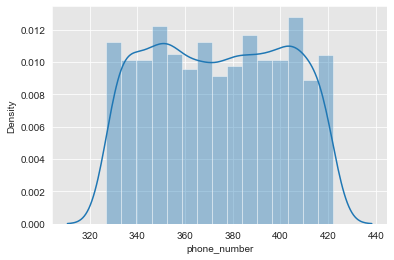

In [144]:
df['phone_number'] = df['phone_number'].map(lambda x: int(x[:3]))
sns.distplot(df['phone_number'])

**Distribution**

Data seems well distributed!

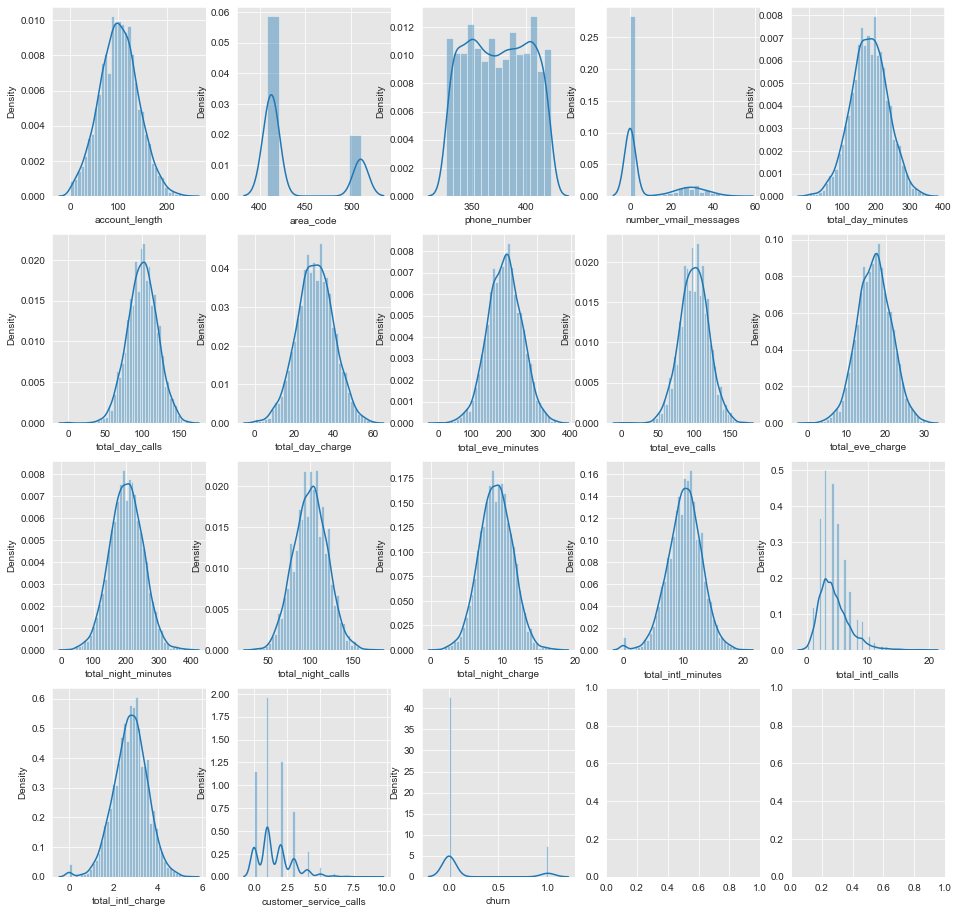

In [145]:
# Identify numerical columns
numeric_cols = []
for i in df.columns:
    if df[i].dtype == 'int64' or df[i].dtype == 'float64':
        numeric_cols.append(i)
numeric_cols.append('churn')
# Define the number of rows and columns you want
n_rows=4
n_cols=5
# Create the subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize =(16,16))

for i, column in enumerate(numeric_cols):
    try:
        sns.distplot(df[column],ax=axes[i//n_cols,i%n_cols])
    except:
        print("failed", " ", column)

**Feature Engineering**

Creating columns that add up charge, calls and minutes rather than keeping them split by the time of day.

In [146]:
# Adding Totals
df['total_minutes'] = (df['total_day_minutes'] + df['total_eve_minutes'] 
                        + df['total_night_minutes'] + df['total_intl_minutes'])
df['total_calls'] = (df['total_day_calls'] + df['total_eve_calls']
                        + df['total_night_calls'] + df['total_intl_calls'])
df['total_charge'] = (df['total_day_charge'] + df['total_eve_charge']
                        + df['total_night_charge'] + df['total_intl_charge'])

# Adding Average Call Length
df['average_call_length'] = round(df['total_minutes'] / df['total_calls'])

# Adding Average Charge per Minute
df['average_charge'] = round(df['total_charge'] / df['total_minutes'], 2)

# Rearrange column names
df = df[['state', 'account_length', 'area_code', 'phone_number',
       'international_plan', 'voice_mail_plan', 'number_vmail_messages',
       'total_day_minutes', 'total_day_calls', 'total_day_charge',
       'total_eve_minutes', 'total_eve_calls', 'total_eve_charge',
       'total_night_minutes', 'total_night_calls', 'total_night_charge',
       'total_intl_minutes', 'total_intl_calls', 'total_intl_charge',
       'total_minutes', 'total_charge', 'total_calls', 
       'average_call_length', 'average_charge', 
       'customer_service_calls', 'churn']]

**Normalize**

In [147]:
# Identify numerical columns
normalize_cols = []
for i in df.columns:
    if 'total' in i:
        normalize_cols.append(i)
    elif 'average' in i:
        normalize_cols.append(i)
normalize_cols.append('number_vmail_messages')

# Create a function to normalize variables
def normalize(variables):
    for i in variables:
        df[i] = ((df[i]-df[i].min())/(df[i].max()-df[i].min()))

# Use the function
normalize(normalize_cols)

In [148]:
df.describe()

,account_length,area_code,phone_number,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,...,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,total_minutes,total_charge,total_calls,average_call_length,average_charge,customer_service_calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,...,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,374.074407,0.158804,0.512472,0.608701,0.512446,0.552599,0.588908,0.552687,...,0.478143,0.511865,0.223972,0.511960,0.512011,0.498767,0.507276,0.329133,0.506451,1.562856
std,39.822106,42.371290,27.467320,0.268399,0.155266,0.121631,0.155255,0.139439,0.117192,0.139459,...,0.136035,0.139592,0.123061,0.139588,0.149749,0.143434,0.153103,0.143262,0.148073,1.315491
min,1.000000,408.000000,327.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,350.000000,0.000000,0.409635,0.527273,0.409624,0.458070,0.511765,0.458104,...,0.387328,0.425000,0.150000,0.425926,0.411520,0.402213,0.404444,0.333333,0.333333,1.000000
50%,101.000000,415.000000,374.000000,0.000000,0.511403,0.612121,0.511402,0.553753,0.588235,0.553866,...,0.478781,0.515000,0.200000,0.514815,0.514899,0.499044,0.506667,0.333333,0.500000,1.000000
75%,127.000000,510.000000,398.000000,0.392157,0.616876,0.690909,0.616868,0.646962,0.670588,0.647040,...,0.570831,0.605000,0.300000,0.605556,0.612785,0.594783,0.608889,0.333333,0.666667,2.000000
max,243.000000,510.000000,422.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9.000000


### Explore


False    2850
True      483
Name: churn, dtype: int64
Percent Churned:
14.49%


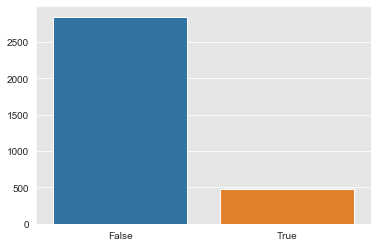

In [149]:
# What portion of users churned
y = df["churn"].value_counts()
sns.barplot(y.index, y.values)
print(y)
print("Percent Churned:")
print(f"{round(y[1]/(y[0]+y[1])*100,2)}%")

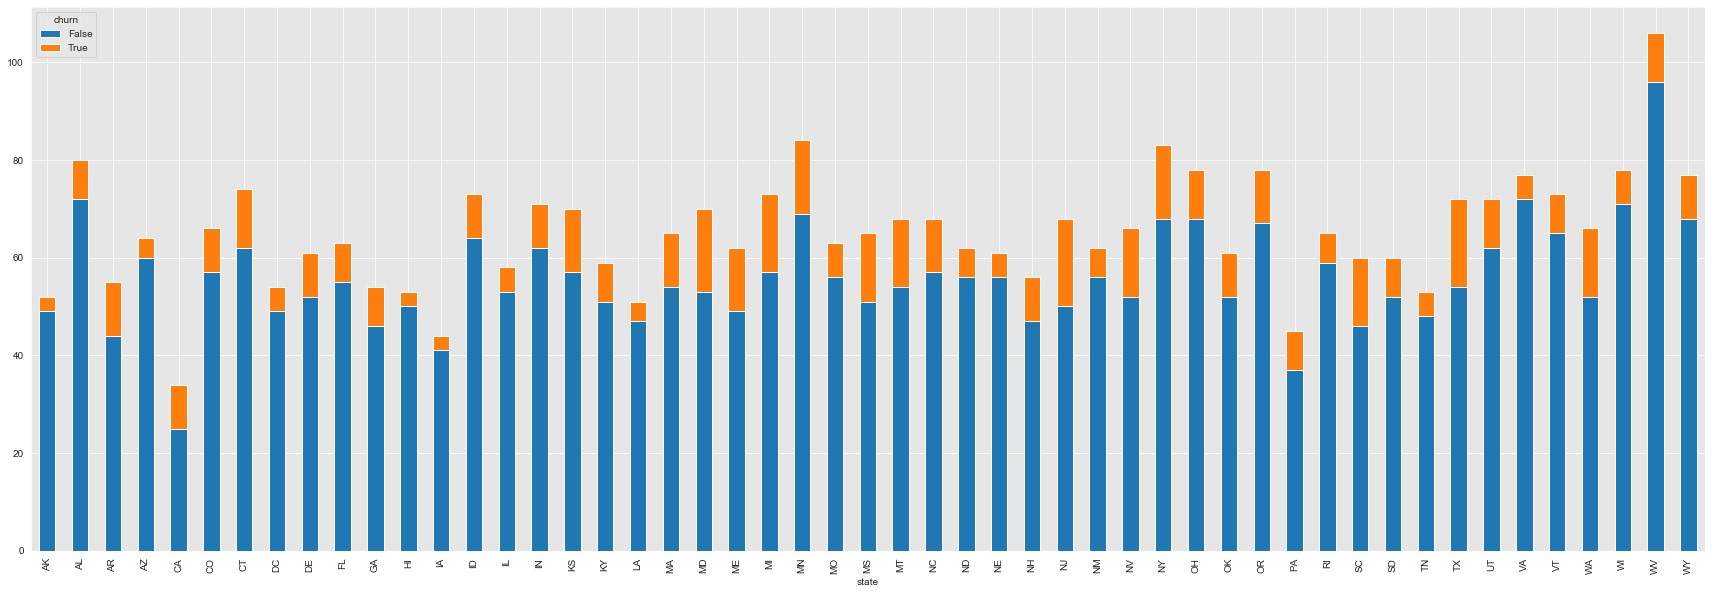

In [150]:
df.groupby(["state", "churn"]).size().unstack().plot(kind='bar', stacked=True, figsize=(30,10))

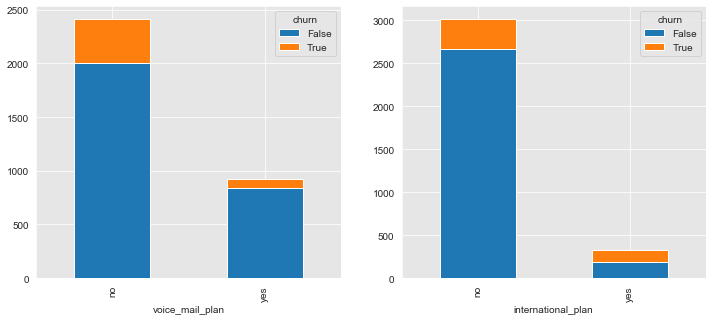

In [151]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize =(12,5))
df.groupby(["voice_mail_plan", "churn"]).size().unstack().plot(kind='bar', stacked=True, ax = axes[0])
df.groupby(["international_plan", "churn"]).size().unstack().plot(kind='bar', stacked=True, ax = axes[1])

Multicollinearity is not important for us in this instance, because it primarily affects Linear Regression Models. Code set in markdown below. 

```
features = [i for i in df.columns]

mask = np.zeros_like(df[features].corr(), dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True 

f, ax = plt.subplots(figsize=(16, 12))
plt.title('Pearson Correlation Matrix',fontsize=25)

sns.heatmap(df[features].corr(),annot=True, cmap='BuGn', 
            linecolor="w", mask = mask)```

**Booleans and Categoricals**

To make life easier everything in the df should be in either int or float format. To that end we will encode all categoricals using LabelEncoder(). 


In [152]:
# Use LabelEncoder to turn categoricals into numbers
label_encoder = preprocessing.LabelEncoder()

# Label Encode boolean variables 
df['international_plan'] = label_encoder.fit_transform(df['international_plan'])
df['voice_mail_plan'] = label_encoder.fit_transform(df['voice_mail_plan'])
df['churn'] = label_encoder.fit_transform(df['churn'])

# One Hot Encoding
df = pd.get_dummies(df, drop_first = True)

df.head()

,account_length,area_code,phone_number,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,...,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY
0,128,415,382,0,1,0.490196,0.755701,0.666667,0.755701,0.542755,...,0,0,0,0,0,0,0,0,0,0
1,107,415,371,0,1,0.509804,0.460661,0.745455,0.460597,0.537531,...,0,0,0,0,0,0,0,0,0,0
2,137,415,358,0,0,0.000000,0.693843,0.690909,0.693830,0.333242,...,0,0,0,0,0,0,0,0,0,0
3,84,408,375,1,0,0.000000,0.853478,0.430303,0.853454,0.170195,...,0,0,0,0,0,0,0,0,0,0
4,75,415,330,1,0,0.000000,0.475200,0.684848,0.475184,0.407754,...,0,0,0,0,0,0,0,0,0,0


In [154]:
# Save the cleaned file
df.to_csv('cleaned_customer_churn.csv')

## Model

We will build several different models to try and achieve the highest accuracy possible. The following will be used:

- **Logistic Regression**
- **Decision Tree**
- **Random Forest**
- **XGBoost**

To try and achieve a sweet-spot model, we will be using GridSearchCV to run through mutliple hyperparameters for each model to try and optimize the model. 

In [3]:
# Load Cleaned file
df = pd.read_csv('cleaned_customer_churn.csv')
df.head()

,Unnamed: 0,account_length,area_code,phone_number,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,...,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY
0,0,128,415,382,0,1,0.490196,0.755701,0.666667,0.755701,...,0,0,0,0,0,0,0,0,0,0
1,1,107,415,371,0,1,0.509804,0.460661,0.745455,0.460597,...,0,0,0,0,0,0,0,0,0,0
2,2,137,415,358,0,0,0.000000,0.693843,0.690909,0.693830,...,0,0,0,0,0,0,0,0,0,0
3,3,84,408,375,1,0,0.000000,0.853478,0.430303,0.853454,...,0,0,0,0,0,0,0,0,0,0
4,4,75,415,330,1,0,0.000000,0.475200,0.684848,0.475184,...,0,0,0,0,0,0,0,0,0,0


In [4]:
#Seperate independent and dependent variables
X = df.drop('churn', axis=1)
y = df['churn']

#Train Test split 75/25 using random state for reproduction
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.75, random_state=42)

In [155]:
#Seperate independent and dependent variables
X_og = df_og.drop('churn', axis=1)
y_og = df_og['churn']

#Train Test split 75/25 using random state for reproduction
X_og_train, X_og_test, y_og_train, y_og_test = train_test_split(X_og, y_og, train_size=.75, random_state=42)

We will use StandardScaler to transform our data to have a distribution with a mean value of 0 and standard deviation 1. 

Then we will use a Regression to set a base model.

**Functions**

Build a helped function that will print out Accuracy, Recall, F1 and AUC scores as well as a Confusion Matrix.

- **Accuracy** is the ratio of correct predictions to incorrect predictions. 
- **Recall** is the ratio of correctly predicted positive outcomes vs all predicted positive outcomes.
- **F1 Score** is the weighted average of Precision and Recall.
- **AUC** (Area Under the Curve) is a mystery to me
- A **Confusion Matrix** is a table containing the number or ratio of observations split by True Positive, False Positive, True Negative and False Negative.  

In [156]:
def scores(y_test, predictions):
    logit_matrix = confusion_matrix(y_test, predictions)
    
    print('Accuracy Score:', accuracy_score(y_test, predictions))
    print('Recall Score:  ', recall_score(y_test, predictions))
    print('F1 Score:      ', f1_score(y_test, predictions))
    print('AUC:           ', roc_auc_score(y_test, predictions))
    print('Confusion Matrix: \n', logit_matrix)
    

**Dummy Classifier**

We will use the sklearn DummyClassfier tool to establish some sort of baseline model that will help us set a floor for accuracy and understand which scores will have to be a focus for us.

Evidently, recall and F1 score will have to be important as we want to focus on getting as many churned customers right. 


 Strategy:  most_frequent
Accuracy Score: 0.8501199040767387
Recall Score:   0.0
F1 Score:       0.0
AUC:            0.5
Logistic Regression Confusion Matrix: 
 [[709   0]
 [125   0]]

 Strategy:  stratified
Accuracy Score: 0.7398081534772182
Recall Score:   0.144
F1 Score:       0.14229249011857706
AUC:            0.494425952045134
Logistic Regression Confusion Matrix: 
 [[599 110]
 [107  18]]

 Strategy:  uniform
Accuracy Score: 0.4892086330935252
Recall Score:   0.512
F1 Score:       0.23104693140794222
AUC:            0.4985952045133991
Logistic Regression Confusion Matrix: 
 [[344 365]
 [ 61  64]]


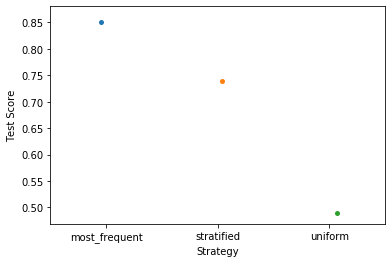

In [7]:
strategies = ['most_frequent', 'stratified', 'uniform']
  
test_scores = []

for s in strategies:
    if s =='constant':
        dclf = DummyClassifier(strategy = s, random_state = 42, constant = None)
    else:
        dclf = DummyClassifier(strategy = s, random_state = 42)
    dclf.fit(X_train, y_train)
    score = dclf.score(X_test, y_test)
    test_scores.append(score)
    predict = dclf.predict(X_test)
    
    
    print('\n Strategy: ', s)
    scores(y_test, predict)

ax = sns.stripplot(strategies, test_scores);
ax.set(xlabel ='Strategy', ylabel ='Test Score')
plt.show()

Because of the disproportionate amount of customers who didn't churn, the first model was able to predict with 85% accuracy by just labeling everything as not going to churn it achieved a relatively high accuracy but because of this, it achieved a zero F1 Score. The models progressively had a lower accuracy but a higher F1 score because they managed to classify increasing numbers of True Positives, but also increased the number of False Positives. 

None of these are sufficiently accurate to be considered as a viable model, but they will serve as a benchmark to see roughly how much we can improve.

**Logistic Regression**

In [59]:
# Log Reg w/ Intercept
logregi = LogisticRegression(fit_intercept = True, C = 1e16, solver = 'liblinear')
logregi.fit(X_train, y_train)

LogisticRegression(C=1e+16, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

Scikit-learn Model 1 Test AUC: 0.8322031029619184
Scikit-learn Model 1 Train AUC: 0.824649892103883
Scikit-learn Model 2 with intercept Test AUC: 0.8335345557122708
Scikit-learn Model 2 with intercept Train AUC: 0.8271509423623379


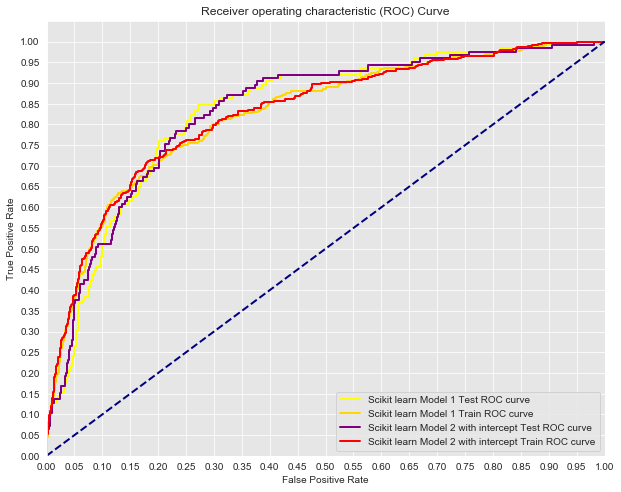

In [96]:
# Log Reg w/ Intercept
logregi = LogisticRegression(fit_intercept = True, C = 1e16, solver = 'liblinear')
logregi.fit(X_train, y_train)

# LogReg w/ Intercept
y_test_score = logregi.decision_function(X_test)
y_train_score = logregi.decision_function(X_train)

test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_score)
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_score)

print('Scikit-learn Model 2 with intercept Test AUC: {}'.format(auc(test_fpr, test_tpr)))
print('Scikit-learn Model 2 with intercept Train AUC: {}'.format(auc(train_fpr, train_tpr)))


plt.plot(test_fpr, test_tpr, color='purple',
         lw=lw, label='Scikit learn Model 2 with intercept Test ROC curve')
plt.plot(train_fpr, train_tpr, color='red',
         lw=lw, label='Scikit learn Model 2 with intercept Train ROC curve')

# Formatting

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [99]:
predicti = logregi.predict(X_test)
scores(predicti, y_test)

Accuracy Score: 0.8465227817745803
Recall Score:   0.4666666666666667
F1 Score:       0.24705882352941178
AUC:            0.667427122940431
Confusion Matrix: 
 [[685 104]
 [ 24  21]]


In [100]:
# Log Reg w/ Intercept
logregi = LogisticRegression(fit_intercept = True, C = 1e16, solver = 'liblinear')
logregi.fit(X_train, y_train)

predicti = logregi.predict(X_test)
scores(predicti, y_test)

# LogReg w/ Intercept
y_test_score = logregi.decision_function(X_test)
y_train_score = logregi.decision_function(X_train)

test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_score)
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_score)

print('Scikit-learn Model 2 with intercept Test AUC: {}'.format(auc(test_fpr, test_tpr)))
print('Scikit-learn Model 2 with intercept Train AUC: {}'.format(auc(train_fpr, train_tpr)))

Accuracy Score: 0.8465227817745803
Recall Score:   0.4666666666666667
F1 Score:       0.24705882352941178
AUC:            0.667427122940431
Confusion Matrix: 
 [[685 104]
 [ 24  21]]
Scikit-learn Model 2 with intercept Test AUC: 0.8335345557122708
Scikit-learn Model 2 with intercept Train AUC: 0.8271509423623379


Solid performance when measuring solely for AUC but when applied to the model as a whole, performance falls significantly, especially with regards to Recall and F1. Will not suffice. 



**GridSearchCV**

We will be using GridSearchCV to tune the parameters of each of the following models we will be using. 

**Decision Tree**

We will be using Cross Validation Score to estimate the skill of each model before measuring the output scores they each achieve.

In [73]:
# Instantiate Decision Tree Classifier
dt_clf = DecisionTreeClassifier(random_state = 42)
dt_cv_score = cross_val_score(dt_clf, X_train, y_train, cv = 3)
mean_dt_cv_score = np.mean(dt_cv_score)


print(f"Mean Cross Validation Score for Decision Tree: {mean_dt_cv_score :.2%}")

Mean Cross Validation Score for Decision Tree: 94.84%


In [30]:
# Set up Decision Tree Parameters for GridSearchCV
dt_param_grid = {
    "criterion": ["gini","entropy"],
    "max_depth": [None, 2, 3, 4, 5, 6],
    "min_samples_split": [2, 5,10],
    "min_samples_leaf": [1, 2, 3, 4, 5, 6]
}

# Instantiate GridSearchCV
dt_grid_search = GridSearchCV(dt_clf, dt_param_grid, cv=3, 
                              return_train_score=True)

# Fit to the data
dt_grid_search.fit(X_train, y_train)

# Mean training score
dt_gs_training_score = np.mean(dt_grid_search.cv_results_['mean_train_score'])

# Mean test score
dt_gs_testing_score = dt_grid_search.score(X_test, y_test)

dt_predictions = dt_grid_search.best_estimator_.predict(X_test)


scores(dt_predictions, y_test)
print(f"Mean Training Score: {dt_gs_training_score :.2%}")
print(f"Mean Test Score: {dt_gs_testing_score :.2%}")
print("Best Parameter Combination Found During Grid Search:")
dt_grid_search.best_params_

Accuracy Score: 0.9808153477218226
Recall Score:   0.990990990990991
F1 Score:       0.9322033898305084
AUC:            0.9851220515120931
Logistic Regression Confusion Matrix: 
 [[708  15]
 [  1 110]]
Mean Training Score: 96.21%
Mean Test Score: 98.08%
Best Parameter Combination Found During Grid Search:


{'criterion': 'gini',
 'max_depth': 5,
 'min_samples_leaf': 6,
 'min_samples_split': 2}

This model has really good performance, almost across the board. Will be hard to beat, and the thing of importance here is the near perfect Recall Score while still maintaining a very solid 93% F1 Score.

**Random Forests**

In [31]:
# Instantiate Random Forest Classifier
rf_clf = RandomForestClassifier(random_state = 42)
mean_rf_cv_score = np.mean(cross_val_score(rf_clf, X_train, y_train, cv=3))

#Estimate Performance
print(f"Mean Cross Validation Score for Random Forest Classifier: {mean_rf_cv_score :.2%}")

Mean Cross Validation Score for Random Forest Classifier: 93.16%


In [32]:
# Set up Random Forest Parameters for GridSearchCV
rf_param_grid = {
    'n_estimators': [10, 30, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 6, 10],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [3, 6]
}

rf_grid_search = GridSearchCV(rf_clf, rf_param_grid, cv=3, return_train_score=True)
rf_grid_search.fit(X_train, y_train)
rf_gs_training_score = np.mean(rf_grid_search.cv_results_['mean_train_score'])
rf_predictions = rf_grid_search.best_estimator_.predict(X_test)

scores(rf_predictions, y_test)
print(f"Mean Training Score: {rf_gs_training_score :.2%}")
print(f"Testing Accuracy: {rf_grid_search.best_score_ :.2%}")
print("")
rf_grid_search.best_params_

Accuracy Score: 0.9460431654676259
Recall Score:   1.0
F1 Score:       0.7804878048780487
AUC:            0.9701591511936339
Logistic Regression Confusion Matrix: 
 [[709  45]
 [  0  80]]
Mean Training Score: 92.57%
Testing Accuracy: 94.24%



{'criterion': 'gini',
 'max_depth': None,
 'min_samples_leaf': 3,
 'min_samples_split': 10,
 'n_estimators': 100}

While Recall is perfect, F1 score is significantly lower, indicating that Precsion is low. Not a good model.

In [33]:
# Parameters
rf_param_grid = {'max_depth': [25, 50, 75],
                        'max_features': ['sqrt'],
                        'criterion': ['gini', 'entropy'],
                        'n_estimators': [100, 300, 500, 1000]}

rf_grid_search = GridSearchCV(rf_clf, rf_param_grid, cv=3, return_train_score=True)
rf_grid_search.fit(X_train, y_train)
rf_gs_training_score = np.mean(rf_grid_search.cv_results_['mean_train_score'])
rf_predictions1 = rf_grid_search.best_estimator_.predict(X_test)

scores(rf_predictions1, y_test)
print(f"Mean Training Score: {rf_gs_training_score :.2%}")
print(f"Testing Accuracy: {rf_grid_search.best_score_ :.2%}")
print("")
rf_grid_search.best_params_

Accuracy Score: 0.960431654676259
Recall Score:   1.0
F1 Score:       0.847926267281106
AUC:            0.9777628032345014
Logistic Regression Confusion Matrix: 
 [[709  33]
 [  0  92]]
Mean Training Score: 100.00%
Testing Accuracy: 95.16%



{'criterion': 'gini',
 'max_depth': 25,
 'max_features': 'sqrt',
 'n_estimators': 500}

The Decision Tree Model is preferred both because of the higher F1, Accuracy, and AUC scores, and because we hit a higher portion of True Positives. The main focus of this project to identify all churns, i.e. maximizing True Positives. 

**XGBoost**

The most powerful model we will use, hopefully this will allow us to improve on the Decision Tree slightly

In [70]:
clf = xgb.XGBClassifier()
clf.fit(X_train, y_train)
training_preds = clf.predict(X_train)
val_preds = clf.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
val_accuracy = accuracy_score(y_test, val_preds)

print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

Training Accuracy: 97.96%
Validation accuracy: 98.2%


In [69]:
xg_clf = xgb.XGBClassifier(random_state = 42)
mean_xg_cv_score = np.mean(cross_val_score(xg_clf, X_train, y_train, cv=3))

print(f"Mean Cross Validation Score for XGBoost Classifier: {mean_xg_cv_score :.2%}")

Mean Cross Validation Score for XGBoost Classifier: 97.64%


In [71]:
# Set up XGBoost Parameters for GridSearchCV
xg_param_grid = {
    "learning_rate": [0.1,0.15],
    'max_depth': [6, 7],
    'min_child_weight': [10, 11,12],
    'subsample': [ 0.7, .8],
    'n_estimators': [5, 30, 100, 250],
}

xg_grid_search = GridSearchCV(xg_clf, xg_param_grid, cv=3, return_train_score=True)
xg_grid_search.fit(X_train, y_train)
xg_gs_training_score = np.mean(xg_grid_search.cv_results_['mean_train_score'])
xg_predictions = xg_grid_search.best_estimator_.predict(X_test)

scores(xg_predictions, y_test)
print(f"Mean Training Score: {xg_gs_training_score :.2%}")
print(f"Testing Accuracy: {xg_grid_search.best_score_ :.2%}")
print("")
xg_grid_search.best_params_

Accuracy Score: 0.973621103117506
Recall Score:   0.9724770642201835
F1 Score:       0.9059829059829061
AUC:            0.9731350838342296
Confusion Matrix: 
 [[706  19]
 [  3 106]]
Mean Training Score: 96.12%
Testing Accuracy: 96.52%



{'learning_rate': 0.1,
 'max_depth': 6,
 'min_child_weight': 10,
 'n_estimators': 250,
 'subsample': 0.8}

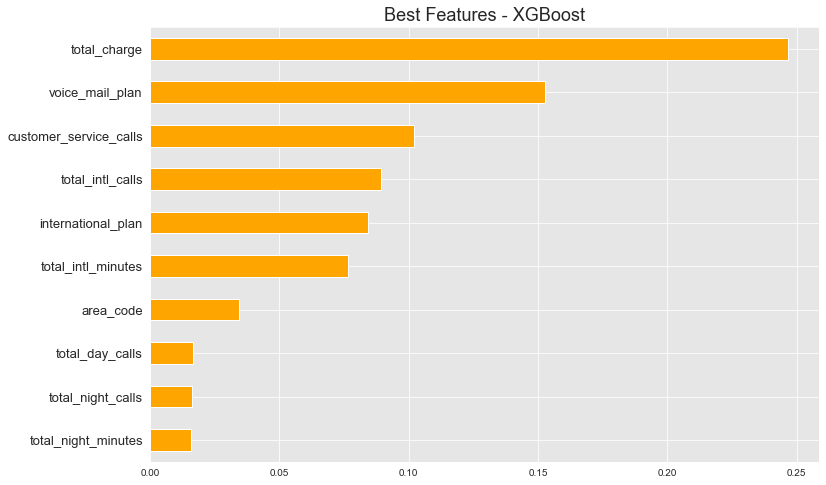

In [95]:
# Find the best features that can be used for predicting churn
xgb_mod = xg_clf.fit(X,y)

(pd.Series(xgb_mod.feature_importances_, index=X.columns).nlargest(10)
   .plot(kind='barh', figsize=[12,8], color = 'orange').invert_yaxis())

plt.yticks(size=13)
plt.title('Best Features - XGBoost', size=18)
plt.show()

In [108]:
X.columns

Index(['Unnamed: 0', 'account_length', 'area_code', 'phone_number',
       'international_plan', 'voice_mail_plan', 'number_vmail_messages',
       'total_day_minutes', 'total_day_calls', 'total_day_charge',
       'total_eve_minutes', 'total_eve_calls', 'total_eve_charge',
       'total_night_minutes', 'total_night_calls', 'total_night_charge',
       'total_intl_minutes', 'total_intl_calls', 'total_intl_charge',
       'total_minutes', 'total_charge', 'total_calls', 'average_call_length',
       'average_charge', 'customer_service_calls', 'state_AL', 'state_AR',
       'state_AZ', 'state_CA', 'state_CO', 'state_CT', 'state_DC', 'state_DE',
       'state_FL', 'state_GA', 'state_HI', 'state_IA', 'state_ID', 'state_IL',
       'state_IN', 'state_KS', 'state_KY', 'state_LA', 'state_MA', 'state_MD',
       'state_ME', 'state_MI', 'state_MN', 'state_MO', 'state_MS', 'state_MT',
       'state_NC', 'state_ND', 'state_NE', 'state_NH', 'state_NJ', 'state_NM',
       'state_NV', 'state_NY', 'st

In [104]:
np.random.seed(1)
explainer = lime.lime_tabular.LimeTabularExplainer(X_train, class_names = ['churn'],
                                                  feature_names = feature_names )

In [107]:
feature_names = X.columns[1:]

## Conclusion

Summarize implications of this work on the real-world problem and stakeholders